##Importing Necessary libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt


Importing the Excel file

In [2]:
from google.colab import files

files.upload()

Saving Dataset.xls to Dataset.xls


{'Dataset.xls': b'PK\x03\x04\x14\x00\x00\x00\x08\x00j4\x7fT\x07AMb\x81\x00\x00\x00\xb1\x00\x00\x00\x10\x00\x00\x00docProps/app.xmlM\x8e=\x0b\x021\x10D\xff\xcaq\xbd\xb7A\xc1Bb@\xd0R\xb0\xb2\x0f{\x1b/\x90dC\xb2B~\xbe9\xc1\x8fn\x1eo\x18F\xdf\ng*\xe2\xa9\x0e-\x86T\x8f\xe3"\x92\x0f\x00\x15\x17\x8a\xb6N]\xa7n\x1c\x97h\xa5cy\x00;\xe7\x91\xce\x8c\xcfHI`\xab\xd4\x1e\xa8\t\xa5\x99\xe6M\xfe\x0e\x8eF\x9fr\x0e\x1e\xadxN\xe6\xea\xb1pe\'\xc3\xa5!\x05\r\xffrm\xde\xa9\xd45\xef&\xf5\x96\x1f\xd6\xf0;i^PK\x03\x04\x14\x00\x00\x00\x08\x00j4\x7fTU\xf1\xb2\xf5\xee\x00\x00\x00+\x02\x00\x00\x11\x00\x00\x00docProps/core.xml\xcd\x92\xc1J\xc40\x10\x86_Ero\'m`\x85\xd0\xedE\xf1\xa4 \xb8\xa0x\x0b\x93\xd9\xdd`\x93\x86d\xa4\xdd\xb7\xb7\xad\xbb]D\x1f\xc0cf\xfe|\xf3\rL\x83Qc\x9f\xe89\xf5\x91\x12;\xca7\xa3\xefB\xd6\x18\xb7\xe2\xc8\x1c5@\xc6#y\x93\xcb)\x11\xa6\xe6\xbeO\xde\xf0\xf4L\x07\x88\x06?\xcc\x81\xa0\x96r\x03\x9e\xd8X\xc3\x06f`\x11W\xa2h\x1b\x8b\x1a\x13\x19\xee\xd3\x19oq\xc5\xc7\xcf\xd4-0\x8b@\x1dy\n\x9c\xa1*+\x10\xe

In [3]:
df = pd.read_excel('Dataset.xls')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 48 columns):
 #   Column                                                                                                                                                                            Non-Null Count  Dtype 
---  ------                                                                                                                                                                            --------------  ----- 
 0   Unnamed: 0                                                                                                                                                                        212 non-null    int64 
 1   Sector                                                                                                                                                                            212 non-null    object
 2   Last page                                                         

#Data Cleaning

After running df.info(), we noticed the following:

1. Column 0 is spurious and needs to be dropped
2. Last page is irrelevent and needs to be dropped

when it comes to columns with missing values in over 30% of the entries, we'll be dropping those columns as well. These columns include:
1. What is your current marital status? [Comment]
2. What is your main source of income? [Comment]
3. What type of income or financial support does your household receive? [Comment]
4. What is your current employment status? [Comment]



In [4]:
df = df.drop(columns=['Unnamed: 0','Last page','Have you smoked at least one full tobacco cigarette (excluding e-cigarettes) once or more in the past 30 days?','What is your current marital status? [Comment]', 'What is your main source of income? [Comment]','What type of income or financial support does your household receive? [Comment]','What is your current employment status? [Comment]'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 41 columns):
 #   Column                                                                                                                                                                            Non-Null Count  Dtype 
---  ------                                                                                                                                                                            --------------  ----- 
 0   Sector                                                                                                                                                                            212 non-null    object
 1   I see myself as someone who is extraverted, enthusiastic:                                                                                                                         212 non-null    object
 2   I see myself as someone who is critical, quarrelsome:             

Following the deletion of certain columns, we'll identify and drop 'redundant' columns with , if any.

In [5]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find redundant columns
redundant_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]

# Drop redundant columns
df = df.drop(columns=redundant_cols)
print("Dropped columns:", redundant_cols)
print(df.info())

Dropped columns: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 41 columns):
 #   Column                                                                                                                                                                            Non-Null Count  Dtype 
---  ------                                                                                                                                                                            --------------  ----- 
 0   Sector                                                                                                                                                                            212 non-null    object
 1   I see myself as someone who is extraverted, enthusiastic:                                                                                                                         212 non-null    object
 2   I see myself as someone who is critical, quarr

Now we want to uniquely encode each non-numeric column with numerics.







In [6]:
def unique_encode_column(df, column_name):
    # Create a unique mapping for the column
    unique_values = df[column_name].unique()
    encoding_map = {value: idx for idx, value in enumerate(unique_values)}

    # Replace the column values with their encoded values
    df[column_name] = df[column_name].map(encoding_map)

    return df, encoding_map

columns_to_encode= list(df.columns)

all_encodings={}

for col in columns_to_encode:
    df, encoding_map = unique_encode_column(df, col)
    all_encodings[col] = encoding_map


print(all_encodings)



{'Sector': {'Private': 0, 'Public': 1}, 'I see myself as someone who is extraverted, enthusiastic:': {'Agree strongly': 0, 'Agree moderately': 1, 'Disagree moderately': 2, 'Agree a little': 3, 'Disagree strongly': 4, 'Disagree a little': 5, 'Neither agree nor disagree': 6}, 'I see myself as someone who is critical, quarrelsome:': {'Disagree moderately': 0, 'Agree moderately': 1, 'Neither agree nor disagree': 2, 'Agree a little': 3, 'Disagree a little': 4, 'Agree strongly': 5, nan: 6}, 'I see myself as someone who is dependable, self-disciplined:': {'Agree strongly': 0, 'Agree moderately': 1, 'Agree a little': 2, 'Neither agree nor disagree': 3, 'Disagree moderately': 4, 'Disagree a little': 5, 'Disagree strongly': 6}, 'I see myself as someone who is anxious, easily upset:': {'Agree moderately': 0, 'Agree a little': 1, 'Disagree strongly': 2, 'Disagree moderately': 3, 'Agree strongly': 4, 'Neither agree nor disagree': 5, 'Disagree a little': 6}, 'I see myself as someone who is open to n

Checking the final DataFrame

In [7]:
print(df.head())

   Sector  I see myself as someone who is extraverted, enthusiastic:  \
0       0                                                  0           
1       0                                                  1           
2       0                                                  2           
3       0                                                  0           
4       0                                                  3           

   I see myself as someone who is critical, quarrelsome:  \
0                                                  0       
1                                                  1       
2                                                  2       
3                                                  0       
4                                                  3       

   I see myself as someone who is dependable, self-disciplined:  \
0                                                  0              
1                                                  1              
2    

Feature Scaling to ensure all features contribute equally to PCA and clustering.
(Reduce the dimensionality of the dataset while preserving maximum variance)

In [8]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)  #standardize features to mean 0 and variance 1

Dimensionality Reduction using PCA

In [11]:
pca = PCA(n_components=2)  #Reduce dataset to 2 dimensions for visualization
data_pca = pca.fit_transform(data_scaled)  #Transform the scaled data

K-Means Clustering we used the Elbow Method to find the optimal number of clusters by plotting inertia (sum of squared distances) against k. The "elbow point" suggests the ideal number of clusters. However we weren't able to really tell just by looking at it so we used silhouette score evaluation

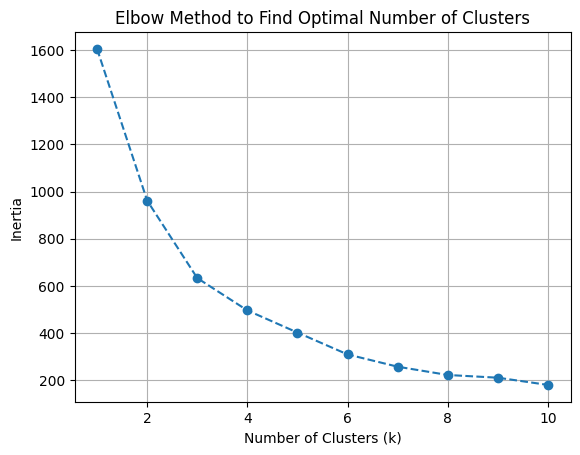

In [12]:
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.title('Elbow Method to Find Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid()
plt.show()


Silhouette Score Evaluation evaluate clustering quality for different k values using the Silhouette Score. Higher scores indicate better-defined clusters.

In [18]:
kmeans_3 = KMeans(n_clusters=3, random_state=42)
clusters_3 = kmeans_3.fit_predict(data_pca)
silhouette_3 = silhouette_score(data_pca, clusters_3)

kmeans_4 = KMeans(n_clusters=4, random_state=42)
clusters_4 = kmeans_4.fit_predict(data_pca)
silhouette_4 = silhouette_score(data_pca, clusters_4)

print(f"Silhouette Score for 3 Clusters: {silhouette_3:.3f}")
print(f"Silhouette Score for 4 Clusters: {silhouette_4:.3f}")




Silhouette Score for 3 Clusters: 0.395
Silhouette Score for 4 Clusters: 0.345
Centroids:  [[ 0.54090183  2.37133634]
 [ 2.52849772 -0.91480711]
 [-1.5322776  -0.55251018]]


Cluster visualization

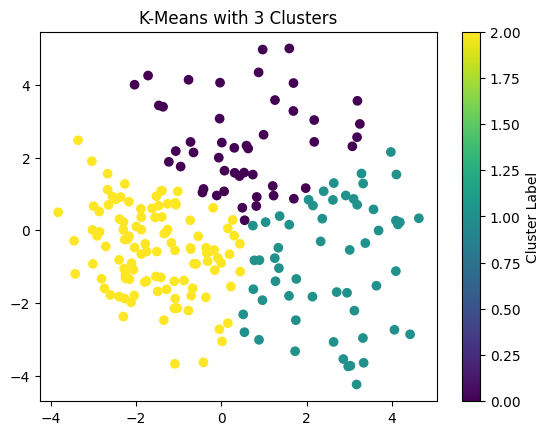

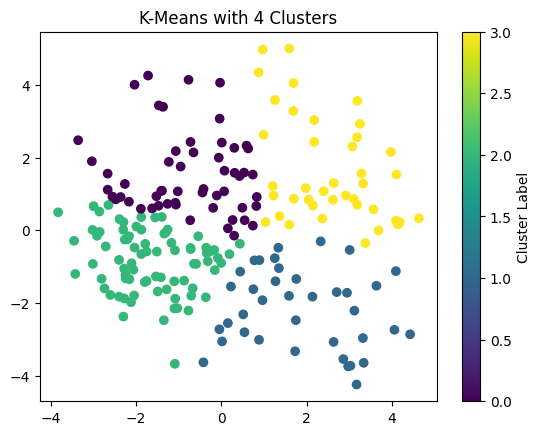

In [14]:
#Visualization for 3 clusters
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters_3, cmap='viridis')
plt.title('K-Means with 3 Clusters')
plt.colorbar(label='Cluster Label')
plt.show()

#Visualization for 4 clusters
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters_4, cmap='viridis')
plt.title('K-Means with 4 Clusters')
plt.colorbar(label='Cluster Label')
plt.show()


Now we will switch to supervised learning we will pass in an example and our model should predict to what cluster it belongs so our Y will be the cluster.

For the first step we split data into training/testing sets and one-hot encode target labels for training.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data_pca, clusters_3, test_size=0.2, random_state=42)

# One-hot encode cluster labels
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))


Training

In [16]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=16, validation_split=0.2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 211 (844.00 B)

 Trainable params: 211 (844.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.1253 - loss: 1.1137 - val_accuracy: 0.3529 - val_loss: 1.0765
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3561 - loss: 1.0560 - val_accuracy: 0.4118 - val_loss: 1.0356
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6367 - loss: 1.0007 - val_accuracy: 0.6471 - val_loss: 0.9928
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7559 - loss: 0.9497 - val_accuracy: 0.7353 - val_loss: 0.9472
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7677 - loss: 0.9257 - val_accuracy: 0.8235 - val_loss: 0.9036
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7770 - loss: 0.8589 - val_accuracy: 0.8529 - val_loss: 0.8608
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8428 - loss: 0.8071 - val_accuracy: 0.8529 - val_loss: 0.8195
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8588 - loss: 0.7515 - val_accuracy: 0.8529 - val_loss: 0.7752
Epoch 9

Evaluating model performance

In [17]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {test_accuracy:.2f}")

predicted_clusters = model.predict(X_test)
predicted_labels = predicted_clusters.argmax(axis=1)

accuracy = accuracy_score(y_test, predicted_labels)
print(f"Model Accuracy: {accuracy:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9327 - loss: 0.1902 
Test Accuracy: 0.93
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Model Accuracy: 0.93


Now we will try to infer what the clusters in our results are, first we applied PCA to be able to visualize the results we don't really know what each axis represent except that they are the axis for PCA we can try to guess taking into consideration we have 3 clusters and our dataset as described (The study's variables fall into three distinct clusters: personality traits based on the Big Five model, sociodemographic and lifestyle factors, and the variable measuring smoking dependence.) We can guess that the three clusters represent the following:

We are gonna think of the clusters as weights for the three clusters given in the dataset.

One is for smoking

One is for lifestyle

One is for emoitional intellegance (Big Five model)


So lets say you are a heavy smoker, have a bad lifestyle, and have low emotional intellegance you will be on the edge of the smoking cluster away from the center.

Same for the two others


Lets say you are a heavy smoker, have a good lifestyle, and bad emotional intellegance you will be between the two cluster (smoking and lifestyle) depends on the intensity you will know where you are the lower the closer to the center the higher the further from the center.

We will try to test our inference by creating 3 examples, all are 3 extremes.

we will see where they end up on the plot if they are on the edges of clusters we are most probably right.


The code will be on github.